In [117]:
import pandas as pd
import numpy as np
import sqlite3
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import itertools
import statsmodels.api as sm
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
logging.basicConfig(filename='logs.log', level=logging.DEBUG, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

conn = sqlite3.connect('../data_eng/HOUSING.db')
cursor = conn.cursor()
df = pd.read_sql("select * from Realtor_Final_Merged", conn)


cursor.close()
conn.close()

df = df.select_dtypes(include=[np.number])

df.head(2)

,month_date_yyyymm,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,...,pending_ratio,quality_flag,year,CPIAUCSL_value,FEDFUNDS_value,UMCSENT_value,RSXFS_value,BOPGSTB_value,HOUST_value,PI_value
0,202309,334450.0,2.0,80.0,0.0,0.0,0.0,2.0,85.0,2918.0,...,1.0,1.0,2023,307.481,5.33,67.9,613076.0,-61542.0,1346.0,23166.1
1,202309,895000.0,30.0,42.0,24.0,0.0,4.0,21.0,575.0,1450.0,...,0.7,0.0,2023,307.481,5.33,67.9,613076.0,-61542.0,1346.0,23166.1


In [136]:
df.shape

(2028464, 23)

In [119]:

# made median days into buckets
df['target_bins'] = pd.qcut(df['median_days_on_market'], q=10, duplicates='drop')  

train_set, temp_set = train_test_split(df, test_size=0.4, stratify=df['target_bins'], random_state=42)

validation_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

train_set = train_set.drop(columns=['target_bins','month_date_yyyymm','year'])
validation_set = validation_set.drop(columns=['target_bins','month_date_yyyymm','year'])
test_set = test_set.drop(columns=['target_bins','month_date_yyyymm','year'])

logging.info(f"Created Train Validate and Test sets")


In [120]:
# using parallel processing 

# do not run unless you want to use all sys resources!!

# def fit_model(variables):
#     X = train_set[list(variables)]
#     X = sm.add_constant(X)
#     y = train_set['median_listing_price']
#     model = sm.OLS(y, X).fit()

#     if all(p < 0.1 for p in model.pvalues[1:]):  
#         return (model.rsquared_adj, model)
#     else:
#         return (float('-inf'), None)


# independent_vars = train_set.drop('median_days_on_market', axis=1)
# all_combinations = []
# for L in range(1, len(independent_vars)+1):
#     all_combinations.extend(itertools.combinations(independent_vars, L))

# with Pool() as pool:
#     results = pool.map(fit_model, all_combinations)

# best_r2, best_model = max(results, key=lambda x: x[0])

# if best_model:
#     print(best_model.summary())

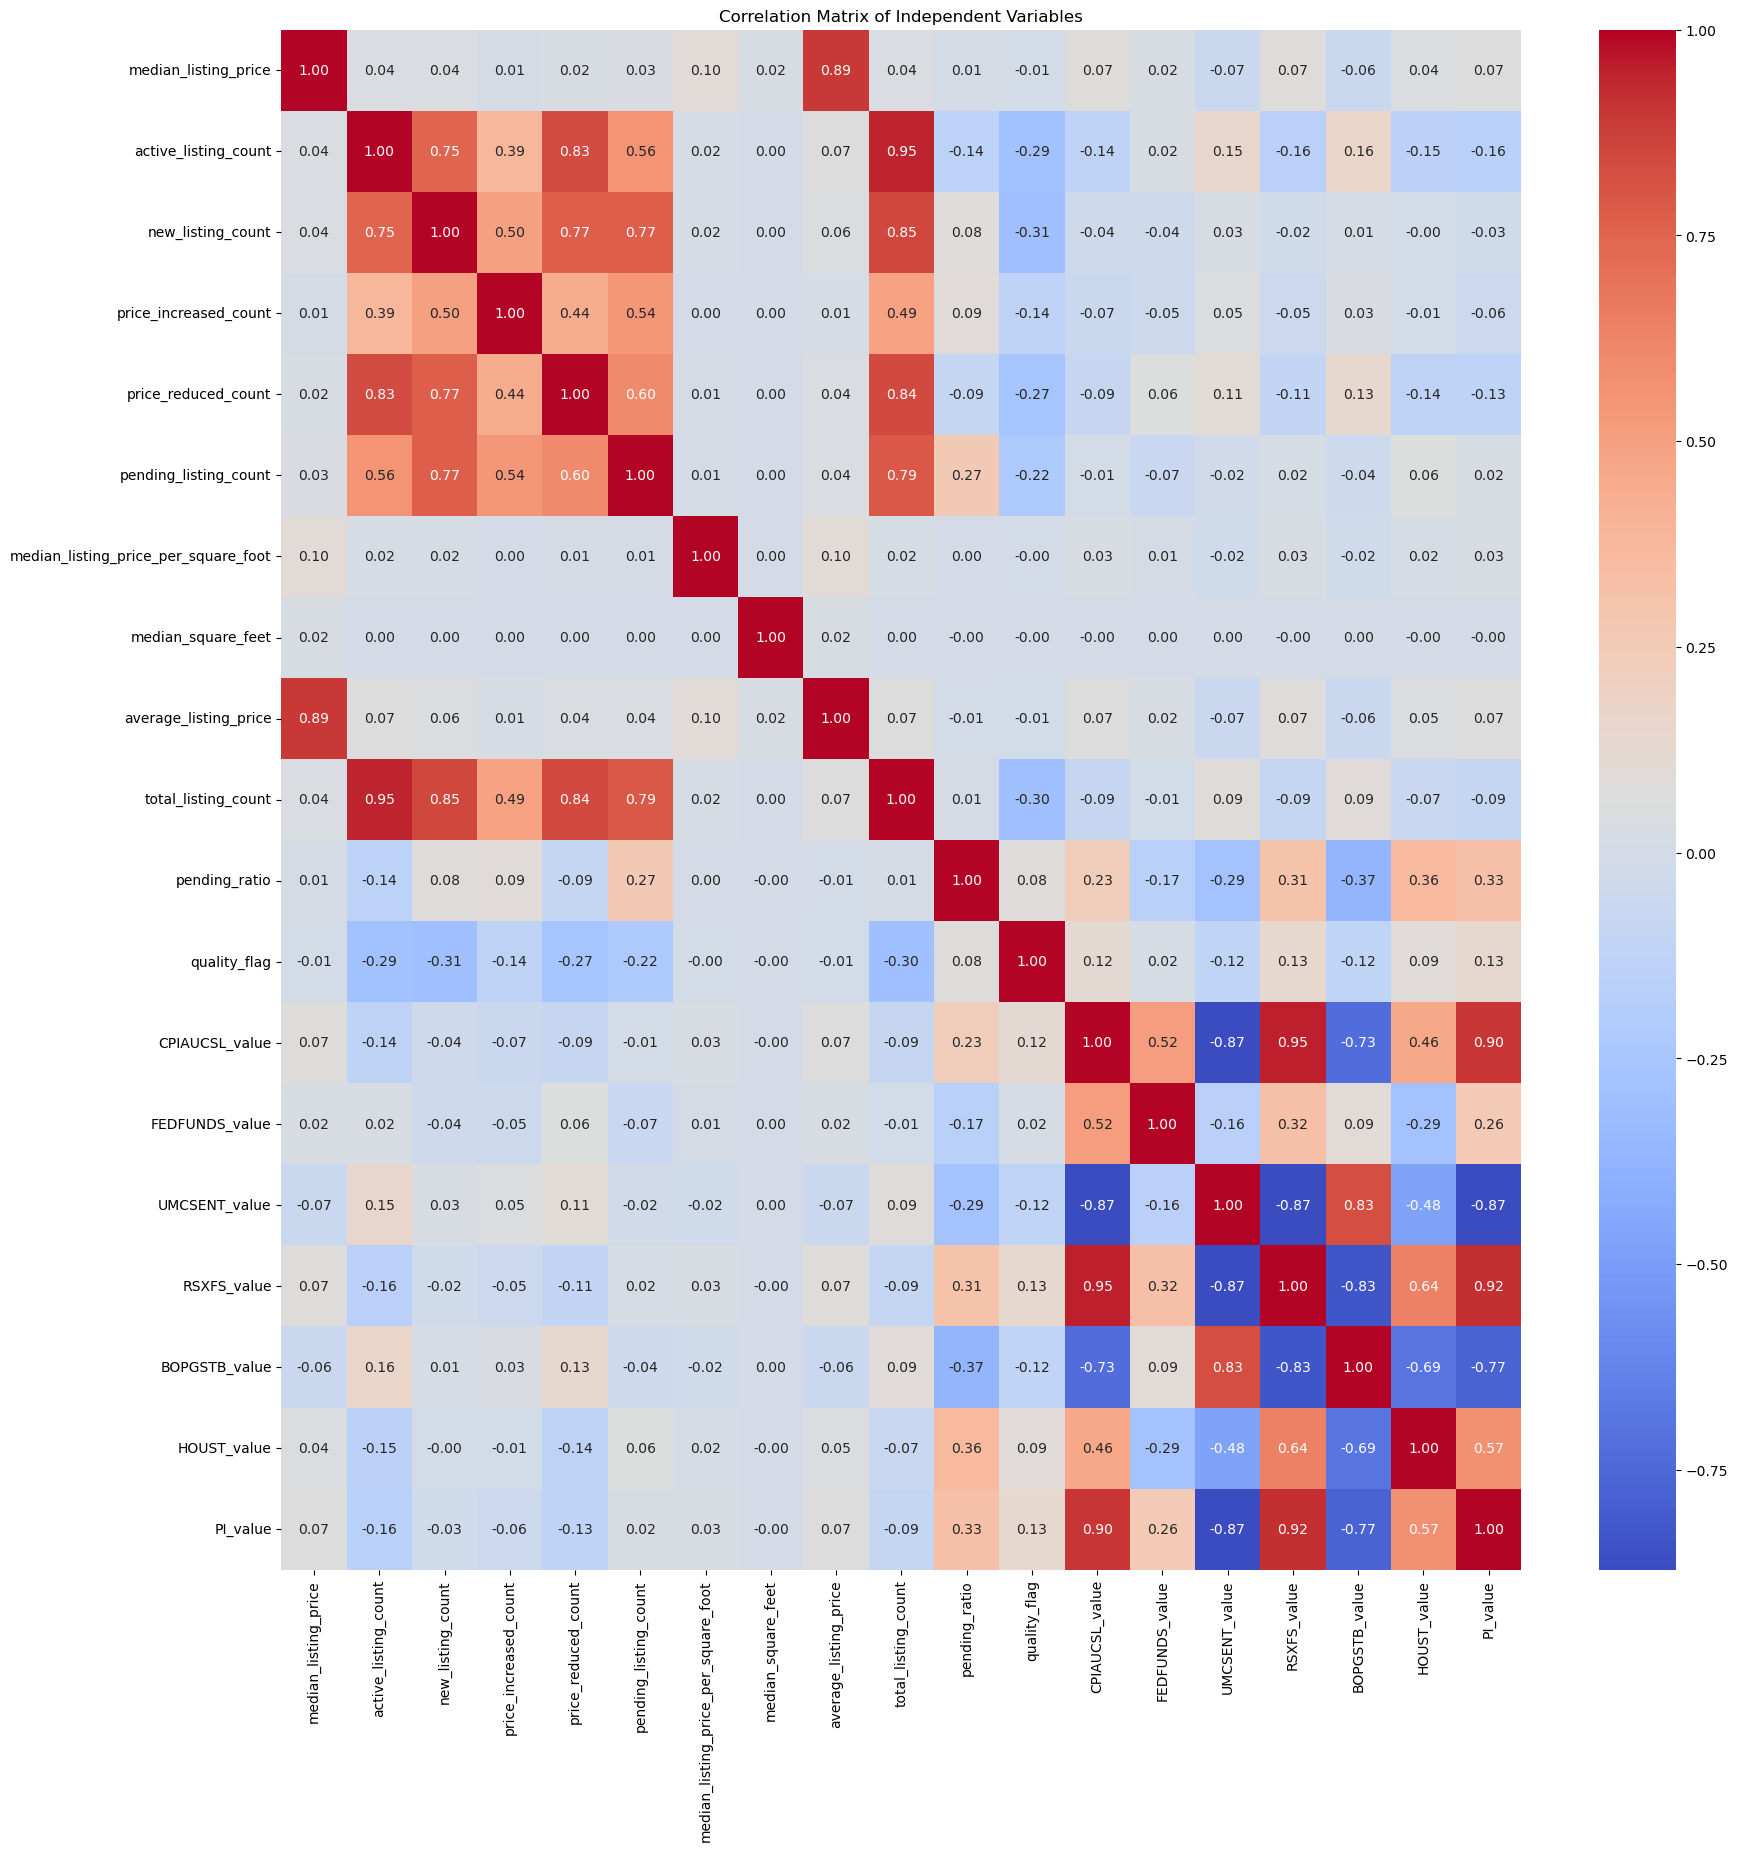

In [121]:
train_set_x = train_set.drop('median_days_on_market', axis=1)

val_set_x = validation_set.drop('median_days_on_market', axis=1)

test_set_x = test_set.drop('median_days_on_market', axis=1)

corr_matrix = train_set_x.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Independent Variables')
plt.show()

In [122]:
# multicollinearity check

threshold = 0.85

highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j))


highly_correlated_pairs



[('average_listing_price', 'median_listing_price'),
 ('total_listing_count', 'active_listing_count'),
 ('total_listing_count', 'new_listing_count'),
 ('UMCSENT_value', 'CPIAUCSL_value'),
 ('RSXFS_value', 'CPIAUCSL_value'),
 ('RSXFS_value', 'UMCSENT_value'),
 ('PI_value', 'CPIAUCSL_value'),
 ('PI_value', 'UMCSENT_value'),
 ('PI_value', 'RSXFS_value')]

Because we are more worried about the predictive power of our regression model, I am less concerned about the multicolinearity. This is why the Threshold was kept at 0.85. 

Now to choose the independent variables to remove:

- average_listing_price (median listing price would be a better indicator)
- total_listing_count (active_listing_count would be a better fit)
- will remove RSXFS_value, CPIAUCSL_value and PI

In [123]:
cols_to_remove = ['average_listing_price', 'total_listing_count', 'RSXFS_value','CPIAUCSL_value','PI_value']

train_set_x = train_set_x.drop(cols_to_remove, axis=1)

val_set_x = val_set_x.drop(cols_to_remove, axis=1)

test_set_x = test_set_x.drop(cols_to_remove, axis=1)

,median_listing_price,active_listing_count,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,pending_ratio,quality_flag,FEDFUNDS_value,UMCSENT_value,BOPGSTB_value,HOUST_value
685530,218000.0,9.0,4.0,0.0,0.0,2.000000,179.0,1564.0,0.235300,1.0,0.09,70.3,-71816.0,1576.0
1079068,177000.0,16.0,0.0,0.0,0.0,22.587914,163.0,1265.0,0.852213,1.0,0.05,72.3,-54700.0,1054.0
1432251,2294055.0,1.0,0.0,0.0,0.0,1.000000,212.0,9290.0,1.000000,1.0,2.42,97.2,-49433.0,1267.0
526760,1295000.0,1.0,0.0,0.0,0.0,1.000000,370.0,3500.0,1.000000,1.0,0.08,62.8,-86960.0,1771.0
1729792,32950.0,4.0,2.0,0.0,0.0,17.815036,33.0,886.0,0.415974,1.0,1.70,98.0,-41421.0,1357.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482874,1950000.0,1.0,0.0,0.0,0.0,19.952811,867.0,2250.0,1.086538,1.0,0.20,59.4,-102536.0,1713.0
425830,149900.0,1.0,0.0,0.0,0.0,1.000000,95.0,1582.0,1.000000,1.0,1.21,50.0,-80851.0,1561.0
92953,927450.0,24.0,8.0,0.0,8.0,6.000000,754.0,1260.0,0.250000,1.0,5.08,64.2,-63718.0,1418.0
166013,576500.0,3.0,6.0,0.0,0.0,5.000000,266.0,2273.0,1.500000,0.0,4.65,62.0,-60403.0,1380.0


In [124]:
# basic linear regression

X = train_set_x
y = train_set['median_days_on_market']


X = sm.add_constant(X)

model_a = sm.OLS(y, X).fit()

model_summary = model_a.summary()
print(model_summary)

                              OLS Regression Results                             
Dep. Variable:     median_days_on_market   R-squared:                       0.150
Model:                               OLS   Adj. R-squared:                  0.150
Method:                    Least Squares   F-statistic:                 1.532e+04
Date:                   Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                           01:03:15   Log-Likelihood:            -6.4256e+06
No. Observations:                1217078   AIC:                         1.285e+07
Df Residuals:                    1217063   BIC:                         1.285e+07
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [125]:
#get MSE on validation set
val_regress = val_set_x
val_regress = sm.add_constant(val_regress)
val_regress_pred = model_a.predict(val_regress)

mse = mean_squared_error(validation_set['median_days_on_market'], val_regress_pred)
print("Mean Square Error for Multivariate Regression Model")
print(mse)

Mean Square Error for Multivariate Regression Model
2256.4419787742872


In [126]:
#log transform the data
independent_vars = train_set_x.columns

for var in independent_vars:
    min_val = train_set_x[var].min()
    shift = np.abs(min_val) + 1
    train_set_x[f'ln_{var}'] = np.log(train_set_x[var] + shift)
    
    min_val = val_set_x[var].min()
    shift = np.abs(min_val) + 1
    val_set_x[f'ln_{var}'] = np.log(val_set_x[var] + shift)
    
    min_val = test_set_x[var].min()
    shift = np.abs(min_val) + 1
    test_set_x[f'ln_{var}'] = np.log(test_set_x[var] + shift)

X = train_set_x[[f'ln_{var}' for var in independent_vars]] 
y = np.log(train_set['median_days_on_market'] + 1)

X = sm.add_constant(X)

model_b = sm.OLS(y, X).fit()

model_summary = model_b.summary()
print(model_summary)

                              OLS Regression Results                             
Dep. Variable:     median_days_on_market   R-squared:                       0.300
Model:                               OLS   Adj. R-squared:                  0.300
Method:                    Least Squares   F-statistic:                 3.721e+04
Date:                   Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                           01:03:17   Log-Likelihood:            -1.1256e+06
No. Observations:                1217078   AIC:                         2.251e+06
Df Residuals:                    1217063   BIC:                         2.251e+06
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [127]:
val_log_regress = val_set_x[[f'ln_{var}' for var in independent_vars]] 
val_log_regress = sm.add_constant(val_log_regress)
pred_log_regress = model_b.predict(val_log_regress)

mse_logreg = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), pred_log_regress)
print("Mean Square Error for Multivariate Regression Model")
print(mse_logreg)

Mean Square Error for Multivariate Regression Model
0.3712861541374382


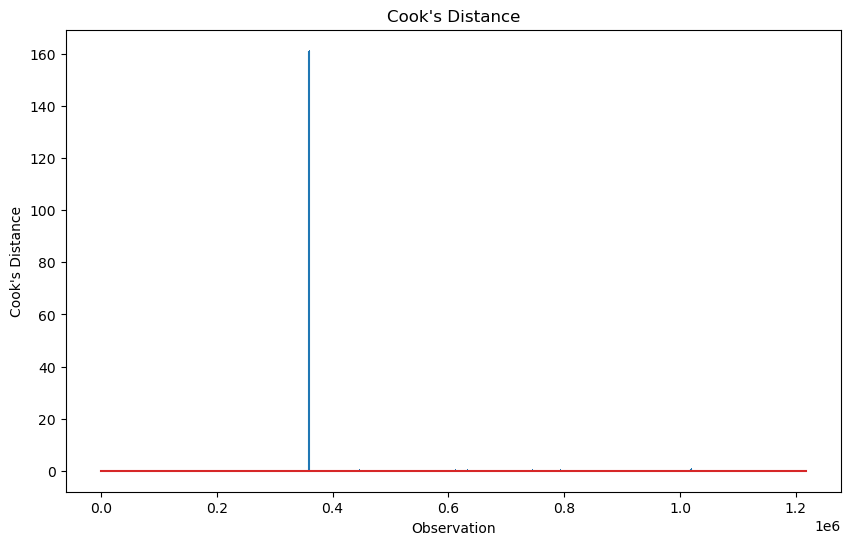

In [128]:
# let's see if there are outliers

influence = model_a.get_influence()

cooks = influence.cooks_distance[0]

n = len(train_set_x)

THRESH = 4/n


outliers = np.where(cooks > THRESH)[0]


plt.figure(figsize=(10,6))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
#plt.axhline(y=threshold, color='r', linestyle='--')
plt.title("Cook's Distance")
plt.xlabel("Observation")
plt.ylabel("Cook's Distance")
plt.show()

In [129]:
max(cooks)

161.2746184506799

In [130]:
len(train_set_x)

1217078

In [131]:
train_set_x = train_set_x.drop(train_set_x.index[outliers])
train_set = train_set.drop(train_set.index[outliers])
len(train_set_x)

1178864

### A little more than 38,000 observations were deemed outliers based on the threshold and removed from the training data. Including one observation that yielded a cooks distance of 161.27, no other observations yielded a cooks distance greater than 1. 

In [63]:
X = train_set_x[[f'ln_{var}' for var in independent_vars]] 
y = np.log(train_set['median_days_on_market'] + 1)

X = sm.add_constant(X)

model_c = sm.OLS(y, X).fit()

model_summary = model_c.summary()
print(model_summary)

                              OLS Regression Results                             
Dep. Variable:     median_days_on_market   R-squared:                       0.327
Model:                               OLS   Adj. R-squared:                  0.327
Method:                    Least Squares   F-statistic:                 4.095e+04
Date:                   Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                           00:30:48   Log-Likelihood:            -1.0194e+06
No. Observations:                1178864   AIC:                         2.039e+06
Df Residuals:                    1178849   BIC:                         2.039e+06
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [64]:
val_log_regress_cooks = val_set_x[[f'ln_{var}' for var in independent_vars]] 
val_log_regress_cooks = sm.add_constant(val_log_regress_cooks)
pred_log_regress_cooks = model_c.predict(val_log_regress_cooks)

mse_logreg_cooks = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), pred_log_regress_cooks)
print("Mean Square Error for Multivariate Regression Model w/ outliers removed")
print(mse_logreg_cooks)

Mean Square Error for Multivariate Regression Model w/ outliers removed
0.37462747583689815


### Removal of outliers does not improve the model based on the MSE.

In [65]:
alphas = (0.05,0.5,2,5,10,100)
#ridge regression on log transformed data 
ridge_cv_non_scaled = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_non_scaled.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], 
                        np.log(train_set['median_days_on_market'] + 1))

RidgeCV(alphas=(0.05, 0.5, 2, 5, 10, 100), store_cv_values=True)

In [68]:
# Lasso Regression with Cross-Validation on log transformed data
lasso_cv_non_scaled = LassoCV(alphas=alphas, cv=5)
lasso_cv_non_scaled.fit(train_set_x[[f'ln_{var}' for var in independent_vars]], 
                        np.log(train_set['median_days_on_market'] + 1))

LassoCV(alphas=(0.05, 0.5, 2, 5, 10, 100), cv=5)

In [79]:
ridge_val_pred_non_scaled = ridge_cv_non_scaled.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])
ridge_val_mse_non_scaled = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), 
                                           ridge_val_pred_non_scaled)
print("Ridge Regression MSE on Validation Set - log transformed not scaled:", ridge_val_mse_non_scaled)
print("Best Ridge alpha:", ridge_cv_non_scaled.alpha_)

ridge_non_scaled_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), ridge_val_pred_non_scaled)
print("Ridge R-squared non scaled:", ridge_non_scaled_r2)


lasso_val_pred_non_scaled = lasso_cv_non_scaled.predict(val_set_x[[f'ln_{var}' for var in independent_vars]])
lasso_val_mse_non_scaled = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), 
                                           lasso_val_pred_non_scaled)
print("Lasso Regression MSE on Validation Set - log transformed not scaled:", lasso_val_mse_non_scaled)
print("Best Lasso alpha:", lasso_cv_non_scaled.alpha_)
lasso_non_scaled_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), lasso_val_pred_non_scaled)
print("Lasso R-squared non scaled:", lasso_non_scaled_r2)


Ridge Regression MSE on Validation Set - log transformed not scaled: 0.3746272479294824
Best Ridge alpha: 10.0
Ridge R-squared non scaled: 0.2961907848748344
Lasso Regression MSE on Validation Set - log transformed not scaled: 0.39635403776643874
Best Lasso alpha: 0.05
Lasso R-squared non scaled: 0.2553728385379037


In [70]:
# lasso and ridge regularization on independent variables using scaler on log transformed data


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_set_x[[f'ln_{var}' for var in independent_vars]])
X_val_scaled = scaler.transform(val_set_x[[f'ln_{var}' for var in independent_vars]])
X_test_scaled = scaler.transform(test_set_x[[f'ln_{var}' for var in independent_vars]])

In [71]:
alphas = np.logspace(-5, 5, 100)

# Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, np.log(train_set['median_days_on_market'] + 1))

# Lasso Regression with Cross-Validation
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train_scaled, np.log(train_set['median_days_on_market'] + 1))

LassoCV(alphas=array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400829e-04, 6.57933225e-04, 8.30217568e-04,
       1.04761575e-03, 1.32194115e-0...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
        cv=5)

In [72]:
ridge_val_pred = ridge_cv.predict(X_val_scaled)
ridge_val_mse = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), ridge_val_pred)
print("Ridge Regression MSE on Validation Set:", ridge_val_mse)


lasso_val_pred = lasso_cv.predict(X_val_scaled)
lasso_val_mse = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), lasso_val_pred)
print("Lasso Regression MSE on Validation Set:", lasso_val_mse)


print("Best Ridge alpha:", ridge_cv.alpha_)
print("Best Lasso alpha:", lasso_cv.alpha_)

Ridge Regression MSE on Validation Set: 0.3746273791005731
Lasso Regression MSE on Validation Set: 0.37462663847541017
Best Ridge alpha: 3.593813663804626
Best Lasso alpha: 1e-05


In [73]:

ridge_coefficients = ridge_cv.coef_
ridge_intercept = ridge_cv.intercept_


lasso_coefficients = lasso_cv.coef_
lasso_intercept = lasso_cv.intercept_


print("Ridge Coefficients:", ridge_coefficients)
print("Ridge Intercept:", ridge_intercept)
print("\n")
print("Lasso Coefficients:", lasso_coefficients)
print("Lasso Intercept:", lasso_intercept)




Ridge Coefficients: [ 0.01171701  0.62876344 -0.66039232 -0.00365938 -0.10195531  0.0612653
 -0.03887897  0.01592077 -0.03836926 -0.01117424  0.00253074  0.04672414
  0.00859749 -0.00290257]
Ridge Intercept: 4.021245193680115


Lasso Coefficients: [ 0.01140376  0.62867649 -0.66034639 -0.00364757 -0.10189409  0.06123695
 -0.03860381  0.01603115 -0.03837071 -0.01116372  0.00251892  0.0467251
  0.0085933  -0.00290611]
Lasso Intercept: 4.021245193680115


In [17]:
ridge_predictions = ridge_cv.predict(X_val_scaled)
lasso_predictions = lasso_cv.predict(X_val_scaled)

# Calculate R-squared
ridge_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), ridge_predictions)
lasso_r2 = r2_score(np.log(validation_set['median_days_on_market'] + 1), lasso_predictions)

print("Ridge R-squared:", ridge_r2)
print("Lasso R-squared:", lasso_r2)

Ridge R-squared: 0.2961905384447552
Lasso R-squared: 0.2961919298513267


In [18]:
ridge_mse = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), ridge_predictions)
lasso_mse = mean_squared_error(np.log(validation_set['median_days_on_market'] + 1), lasso_predictions)

print("Ridge MSE:", ridge_mse)
print("Lasso MSE:", lasso_mse)

Ridge MSE: 0.3746273791005731
Lasso MSE: 0.37462663847541017


the r^2 value actually decreased using the regularization techniques, lets try using the original log-log model we created

In [19]:
X = val_set_x[[f'ln_{var}' for var in independent_vars]] 
y = np.log(validation_set['median_days_on_market'] + 1)

X = sm.add_constant(X)

model_d = sm.OLS(y, X).fit()

model_summary = model_d.summary()
print(model_summary)

                              OLS Regression Results                             
Dep. Variable:     median_days_on_market   R-squared:                       0.303
Model:                               OLS   Adj. R-squared:                  0.303
Method:                    Least Squares   F-statistic:                 1.257e+04
Date:                   Wed, 29 Nov 2023   Prob (F-statistic):               0.00
Time:                           21:19:58   Log-Likelihood:            -3.7466e+05
No. Observations:                 405693   AIC:                         7.493e+05
Df Residuals:                     405678   BIC:                         7.495e+05
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

again, it seems that a simple log-log model seems to provide a better output

In [20]:
test_set_x

,median_listing_price,active_listing_count,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,pending_ratio,quality_flag,...,ln_price_reduced_count,ln_pending_listing_count,ln_median_listing_price_per_square_foot,ln_median_square_feet,ln_pending_ratio,ln_quality_flag,ln_FEDFUNDS_value,ln_UMCSENT_value,ln_BOPGSTB_value,ln_HOUST_value
1355788,399900.0,25.0,8.0,0.0,10.0,2.000000,209.0,1852.0,0.080000,1.0,...,2.397895,1.098612,5.347108,7.525101,0.076961,0.693147,1.238374,5.006627,10.901321,7.682943
1693789,117500.0,3.0,0.0,0.0,0.0,2.000000,108.0,1378.0,0.666700,0.0,...,0.000000,1.098612,4.691348,7.229839,0.510846,0.000000,1.085189,5.003275,10.875478,7.665753
1746572,207450.0,5.0,2.0,0.0,0.0,3.000000,69.0,2329.0,0.600000,1.0,...,0.000000,1.386294,4.248495,7.754053,0.470004,0.693147,1.011601,5.003946,11.020529,7.733246
1893079,263855.0,5.0,6.0,0.0,4.0,12.000000,192.0,1530.0,2.300000,1.0,...,1.609438,2.564949,5.262690,7.334329,1.193922,0.693147,0.792993,5.007296,10.952104,7.695758
232860,797000.0,95.0,30.0,0.0,44.0,36.000000,333.0,2461.0,0.378900,1.0,...,3.806662,3.610918,5.811141,7.809135,0.321286,0.693147,1.682688,4.752728,10.365994,7.725771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773562,131225.0,124.0,38.0,0.0,26.0,1.000000,81.0,1651.0,0.008100,0.0,...,3.295837,0.693147,4.406719,7.410347,0.008067,0.000000,1.007958,5.009301,10.940366,7.697121
754696,79900.0,2.0,0.0,0.0,0.0,1.000000,66.0,1236.0,0.500000,1.0,...,0.000000,0.693147,4.204693,7.121252,0.405465,0.693147,0.104360,4.897093,10.495654,7.834392
1892617,611500.0,3.0,0.0,0.0,0.0,18.638962,214.0,3254.0,0.408217,1.0,...,0.000000,2.977515,5.370638,8.088255,0.342325,0.693147,0.792993,5.007296,10.952104,7.695758
1253202,425900.0,207.0,100.0,4.0,60.0,121.000000,227.0,1985.0,0.584500,0.0,...,4.110874,4.804021,5.429346,7.594381,0.460269,0.000000,0.955511,4.995860,11.060070,7.728416


In [21]:
test_set_x_ln = test_set_x[[f'ln_{var}' for var in independent_vars]]

intercept = np.ones((test_set_x_ln.shape[0], 1))
test_set_x_with_intercept = np.hstack((intercept, test_set_x_ln))
predictions = model_d.predict(test_set_x_with_intercept)


# Calculate metrics
mae = mean_absolute_error(np.log(test_set['median_days_on_market'] + 1), predictions)
mse = mean_squared_error(np.log(test_set['median_days_on_market'] + 1), predictions)
rmse = np.sqrt(mse)
r2 = r2_score(np.log(test_set['median_days_on_market'] + 1), predictions)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)

Mean Absolute Error (MAE): 0.43945966519261265
Mean Squared Error (MSE): 0.3714268543322194
Root Mean Squared Error (RMSE): 0.6094479914908403
R-squared: 0.3007547781231341
